In [ ]:

#%%bash
#wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B4KI-B-t3wTjbElMTS1DVldQUnc' -O Jewellery.tar.gz
#tar xf Jewellery.tar.gz
#rm Jewellery/*.gz
#rm Jewellery/*.zip

In [1]:

import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision import models, transforms, datasets
from PIL import Image

In [2]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    Source: https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:
transforms_ = transforms.Compose([
    transforms.Resize(size=[224, 224], interpolation=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
dataset = ImageFolderWithPaths('/home/praveen/Desktop/notebooks_jupyter/notebooks_jupyter/CBIR/CBIR/database', transforms_) # our custom dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [4]:

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet50(pretrained=True)

In [5]:
def pooling_output(x):
    global model
    for layer_name, layer in model._modules.items():
        x = layer(x)
        if layer_name == 'avgpool':
            break
    return x

In [6]:

# iterate over data
image_paths = []
descriptors = []
model.to(DEVICE)
with torch.no_grad():
    model.eval()
    for inputs, labels, paths in dataloader:
        result = pooling_output(inputs.to(DEVICE))
        descriptors.append(result.cpu().view(1, -1).numpy())
        image_paths.append(paths)
        torch.cuda.empty_cache()

In [7]:
#!wget https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
#!tar xvjf faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
#!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
#!pip install mkl

In [8]:

import numpy as np
import faiss


index = faiss.IndexFlatL2(2048)
descriptors = np.vstack(descriptors)
index.add(descriptors)

In [14]:
np.shape(descriptors)

(78, 2048)

In [9]:

query_image = '/home/praveen/Desktop/notebooks_jupyter/notebooks_jupyter/CBIR/CBIR/angle_single_wo50.jpeg'
img = Image.open(query_image)

input_tensor = transforms_(img)
input_tensor = input_tensor.view(1, *input_tensor.shape)
with torch.no_grad():
    query_descriptors = pooling_output(input_tensor.to(DEVICE)).cpu().numpy()
    distance, indices = index.search(query_descriptors.reshape(1, 2048), 9)

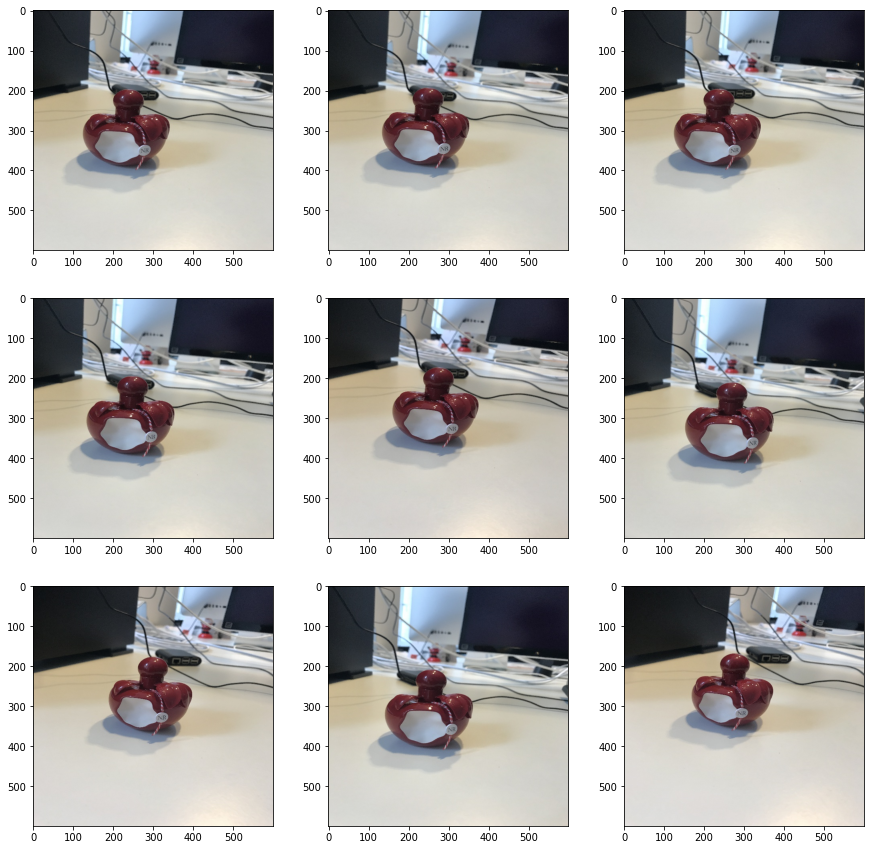

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
for file_index, ax_i in zip(indices[0], np.array(ax).flatten()):
    ax_i.imshow(plt.imread(image_paths[file_index][0]))

plt.show()